In [1]:
import pickle
with open("vonMisesData_100neurons.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters] = pickle.load(input_file)

In [2]:
# All imports here...
import numpy as np

import time

from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)))
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [4]:

t0 = time.time();
# Train model with first environment
NTrain = 90
NTest = 10
BinWidth = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinWidth)
TrainingData = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append([])
    for k in range(NTrain) :
        TrainingData[w].append(BinSpikeRasters(SpikeRasters[w][k], BinWidth=BinWidth, NBins=NBins))
t1 = time.time();
print("Time elapsed for binning: ", t1-t0)




Time elapsed for binning:  0.43337392807006836


In [63]:
[r,c] = TrainingData[w][0].shape
StackedTrainingData = np.array((r,c))
TrainingSequenceLengths = []


for idx in range(len(TrainingData[0])) :
    #l = np.random.random_integers(r/2,r)
    l = r
    TrainingSequenceLengths.append(l)

    if (idx == 0) :
        StackedTrainingData = TrainingData[0][idx][0:l,:]
    else :
        StackedTrainingData = np.vstack((StackedTrainingData,TrainingData[0][idx][0:l,:]))


         2     -106563.2067       +4887.3102
         3     -105998.4070        +564.7996
         4     -105910.9680         +87.4390
         5     -105892.9757         +17.9923
         6     -105885.2564          +7.7193
         7     -105882.0186          +3.2378
         8     -105881.3267          +0.6918
         9     -105881.1105          +0.2162
        10     -105880.9959          +0.1147
        11     -105880.9312          +0.0647
        12     -105880.8955          +0.0357
        13     -105880.8763          +0.0192
        14     -105880.8663          +0.0101
        15     -105880.8610          +0.0052


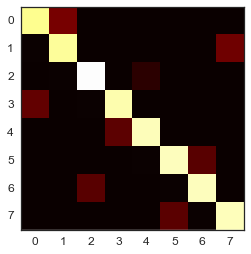

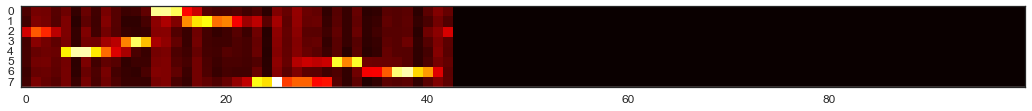

In [66]:
# Watch as training progresses
NStates = 8

from sklearn.cluster import KMeans

NPred = KMeans(n_clusters=NStates).fit(StackedTrainingData)
#sns.set(rc={'figure.figsize': (10, 4),'lines.linewidth': 0, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
#sns.set_style("dark")
#plt.imshow(NPred.cluster_centers_,interpolation="none", cmap='hot')

model = hmm.PoissonHMM(n_components=NStates, n_iter=20, init_params='stm', params='stm', verbose=True)

banded = np.zeros((NStates,NStates))
for i in range(NStates):
    for j in range(NStates) :
        if i < j :
            banded[i][j] = 0.5**(np.abs(i-j))
        else:
            banded[i][j] = 0.1**(np.abs(i-j))

from hmmlearn.utils import normalize
banded = normalize(banded, axis=1)

#model.transmat_ = banded
#model.means_ = NPred.cluster_centers_
#model.means_ = np.dot(np.ones((NStates,1)), np.mean(StackedTrainingData,axis=0,keepdims=True))
#model.means_[model.means_ < np.percentile(model.means_,50)] = 0

model.fit(StackedTrainingData, lengths=TrainingSequenceLengths)
plt.figure()
plt.imshow(model.transmat_,interpolation="none", cmap='hot')
plt.figure()
plt.imshow(model.means_,interpolation="none", cmap='hot')



In [60]:
TrainingSequenceLengths[-1]

array([ 40.])

In [ ]:
sns.set(rc={'figure.figsize': (40, 25),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
from hinton import hinton
f, axarr = plt.subplots(2,6,squeeze=False)


#model = hmm.PoissonHMM(n_components=NStates, n_iter=5, init_params='stm', params='t')
#model = hmm.PoissonHMM(n_components=NStates, n_iter=1, covariance_type='diag', init_params='stm', params='tmc')
model.fit(StackedTrainingData, lengths=TrainingSequenceLengths[0])
plt.sca(axarr[0,0])
plt.imshow(model.transmat_,interpolation="none", cmap='magma')
plt.sca(axarr[1,0])
plt.imshow(model.means_.T,interpolation="none", cmap='hot')

initial_model = model

for idx in range(5) :
    # Build an HMM instance and set parameters
    newmodel = hmm.PoissonHMM(n_components=NStates, n_iter=5, init_params='', params='tm')
    newmodel.transmat_ = model.transmat_
    newmodel.startprob_ = model.startprob_
    newmodel.means_ = model.means_
    #newmodel._covars_ = model._covars_
    model = newmodel
    model.fit(StackedTrainingData, lengths=TrainingSequenceLengths[0])
    plt.sca(axarr[0,idx+1])
    plt.imshow(model.transmat_,interpolation="none", cmap='magma')
    plt.sca(axarr[1,idx+1])
    plt.imshow(model.means_.T,interpolation="none", cmap='hot')



In [ ]:
# Watch as training progresses
NStates = 20


model = hmm.PoissonHMM(n_components=NStates, n_iter=5, init_params='st', params='t')
#model = hmm.PoissonHMM(n_components=NStates, n_iter=5, init_params='stm', params='t')
#model = hmm.PoissonHMM(n_components=NStates, n_iter=1, covariance_type='diag', init_params='stm', params='tmc')

model.transmat_ = np.ones((NStates,NStates))/NStates
model.means_ = NPred.cluster_centers_
#model.means_[model.means_ < np.percentile(model.means_,95)] = 0
model.fit(StackedTrainingData, lengths=TrainingSequenceLengths[0])


sns.set(rc={'figure.figsize': (18, 8),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })

ax = plt.subplot2grid((1,6),(0,0))
plt.sca(ax)
hinton(model.transmat_.T)
#plt.imshow(model.transmat_,interpolation="none", cmap='hot')
#plt.imshow(model.means_.T,interpolation="none", cmap='hot')


banded = np.zeros((NStates,NStates))
for i in range(NStates):
    for j in range(NStates) :
        banded[i][j] = 0.5**(np.abs(i-j))
from hmmlearn.utils import normalize
banded = normalize(banded, axis=1)

def min_row_distance(M, N) :
    assert M.shape == N.shape
    min_distance = 1000
    min_match_rows = [0,0]
    [r,c] = M.shape
    for i in range(r) :
        for j in range(r) :
            d = sum( (M[i,:] - N[j,:])**2 )
            if (d < min_distance) :
                min_match_rows = [i,j]
                min_distance = d
    return [min_match_rows, min_distance]

bb = banded
tm = np.copy(model.transmat_)
dists = np.zeros(NStates)
new_transmat = np.zeros(tm.shape)
row_list = np.zeros(NStates)
[min_rows, min_distance] = min_row_distance(bb,tm)

for r in range(NStates) :
    [min_rows, min_distance] = min_row_distance(bb,tm)
    new_transmat[min_rows[0],:] = tm[min_rows[1],:]
    row_list[min_rows[0]] = min_rows[1]
    bb[min_rows[0],:] = np.nan
    tm[min_rows[1],:] = np.nan
    dists[r] = min_distance

new_means = np.zeros(model.means_.shape)
for i in range(NStates) :
    new_means[i,:] = model.means_[row_list[i],:]
    
ax = plt.subplot2grid((1,6),(0,1))
plt.sca(ax)
hinton(new_transmat.T)
#plt.imshow(new_transmat,interpolation="none", cmap='hot')
ax = plt.subplot2grid((1,6),(0,2), colspan=4)
plt.sca(ax)
plt.imshow(new_means,interpolation="none", cmap='hot')



In [ ]:
newmodel = hmm.PoissonHMM(n_components=NStates, n_iter=10, init_params='s', params='tm')
newmodel.transmat_ = new_transmat
newmodel.means_ = model.means_
newmodel.fit(StackedTrainingData, lengths=TrainingSequenceLengths[0])
ax = plt.subplot2grid((1,4),(0,1))
plt.sca(ax)
hinton(newmodel.transmat_.T)
#plt.imshow(new_transmat,interpolation="none", cmap='hot')
ax = plt.subplot2grid((1,4),(0,2), colspan=4)
plt.sca(ax)
plt.imshow(newmodel.means_,interpolation="none", cmap='hot')


In [ ]:
# Compare different numbers of states
DifferentStateNumberModels = []
NStates = [8,10,12]
t0 = time.time();
for n in NStates :
    model = hmm.PoissonHMM(n_components=n, n_iter=8, tol=1e-4, init_params='smt')
    DifferentStateNumberModels.append(model)

for idx in range(len(NStates)) :
    t1 = time.time();
    # Build an HMM instance and set parameters
    DifferentStateNumberModels[idx].fit(StackedTrainingData, lengths=TrainingSequenceLengths[0])
    t2 = time.time();
    print(t2-t1)
t3 = time.time();
print(t3-t0) # ~120 s total

In [ ]:
from hinton import hinton
f, axarr = plt.subplots(1,len(NStates))
for idx in range(len(NStates)) :
    plt.sca(axarr[idx])
    hinton(DifferentStateNumberModels[idx].transmat_)



In [ ]:
DifferentStateNumberSequenceLL = []
t1 = time.time();
for idx in range(len(NStates)) :
    DifferentStateNumberSequenceLL.append(np.zeros(NTest))
    
for idx in range(len(NStates)) :
    for i in range(NTest) :
        DifferentStateNumberSequenceLL[idx][i] = DifferentStateNumberModels[idx].score(BinSpikeRasters(SpikeRasters[0][NTrain + i]))
    t2 = time.time();
    print(t2-t1)
    
meanLL = []
for ll in DifferentStateNumberSequenceLL:
    meanLL.append(np.mean(ll))
    
print(meanLL)